<a href="https://colab.research.google.com/github/acheshkov/aibolit-ml/blob/ranking_patterns/pairwise_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [0]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import torch.optim as optim
import torch
import torch.nn as nn
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge, HuberRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, classification_report, confusion_matrix 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import datasets, linear_model

from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.base import clone
import seaborn as sns

from itertools import permutations, combinations
import scipy.special
import random
import math

from sklearn.svm import SVC 
from yellowbrick.classifier import ClassificationReport
from sklearn.linear_model import LogisticRegression
!pip install yellowbrick

# Introduction
---

## Pairwise importance ranking

Having snippet of code and its patterns we need sort them according to its importance with respect to target variable. In our case target variable associated with code quality. At first step we are going to train binary *classifier* to predict which of two code snippets has better quality. To do this we are going to train classifier on the subset of *combinations of pairs*. 

To figure out the pattern better to change we do *pairwise comparsion* on the set 
of modification of original vector of patterns. This set of modifications obtained by decrementing every patterns by one. Having pairwise comparison we apply *topological sort* to get linearly ordered list of modifications. Having this ordered list of modifications we get desired sorted list of patterns by importance. 


# Prepate dataset

In [2]:
COLUMNS_FEATURES =  [
  'var_middle_number', 'this_find_number',
  'string_concat_number', 'instance_of_number',
  'method_chain_number', 'var_decl_diff_number_11', 
  'var_decl_diff_number_7', 'var_decl_diff_number_5', 
  'super_method_call_number', 'force_type_cast_number',
  'entropy', 'halstead volume', 'ncss_lightweight',
  'left_spaces_var','right_spaces_var','max_left_diff_spaces',
  'max_right_diff_spaces', 'asserts_number', 'setter_number',
  'empty_rethrow_number', 'prohibited_class_names_number',
  'return_in_if_number', 'impl_multi_number',
  'many_prim_ctors_number','multiple_try_number',
  'non_final_field_number','null_check_number',
  'part_sync_number','red_catch_number',
  'return_null_number'
]

ONLY_PATTERNS = ['var_middle_number', 'this_find_number','string_concat_number', 'instance_of_number',
'method_chain_number', 'var_decl_diff_number_11', 'var_decl_diff_number_7', 'var_decl_diff_number_5', 
'super_method_call_number', 'force_type_cast_number','asserts_number', 'setter_number', 'empty_rethrow_number', 
'prohibited_class_names_number', 'return_in_if_number', 'impl_multi_number',
'many_prim_ctors_number','multiple_try_number', 'non_final_field_number','null_check_number', 
'part_sync_number','red_catch_number', 'return_null_number']


FEATURES_NUMBER = len(ONLY_PATTERNS)
FEATURES_NUMBER

23

When reading dataset, we've exlcuded some outliers: $npath\_method\_avg > 100000$ , Cyclomatic complexity (CC) > 50 and $CC < 4$

In [0]:
scale_ncss=False
scale=False
# import and initialize dataset
df = pd.read_csv('dataset8.csv')
df = df.dropna().drop_duplicates(subset=df.columns.difference(['filename']))
df = df[(df.ncss_lightweight > 20) & (df.ncss_lightweight < 100) & (df.npath_method_avg < 100000.00) & (df.cyclo < 50) & (df.cyclo > 4)].copy().reset_index()
df.rename(columns = {'for_type_cast_number':'force_type_cast_number'}, inplace = True) 
df = df[~df["filename"].str.lower().str.contains("test")]
df.drop('filename', axis=1, inplace=True)
df.drop('index', axis=1, inplace=True)

Target variable we are going to predict is $CC$. We've decided to choose only patterns as features, without metrics

In [0]:
Y = df[['cyclo']].copy().values
if scale_ncss:
    new = pd.DataFrame(df[ONLY_PATTERNS].values / df['ncss_lightweight'].values.reshape((-1, 1)))
else:
    new = df[ONLY_PATTERNS].copy()
if scale:
  X = pd.DataFrame(StandardScaler().fit_transform(new.values), columns=new.columns, index=new.index).values
else:
  X = new

In [0]:
indices = X.index.values.tolist()
perm = permutations(indices, 2)
len(list(perm))

152016570

The number of all possible pairs is huge, so we select randomly $k$ samples and find all 2-permutations of $k$ samples.

In [0]:
import csv

def generate_full_permutations_dataset(d, desired_dataset_size, df, filename="out.csv"):
  def to_bool(s):
    return 1 if s else 0

  def calc_closest_dataset_size_using_permutation(dataset_size):
    # 2-permuations of n =  n*(n-1)
    return int(math.sqrt(dataset_size))

  indices = []
  real_patterns_number = calc_closest_dataset_size_using_permutation(desired_dataset_size)
  random_indices = random.sample(d.index.tolist(), real_patterns_number)
  perms = permutations(random_indices, 2)
  lst = list(perms)
  matrix = []
  for _, val in tqdm(enumerate(lst), total=len(lst)):
    x, y = val[0], val[1]
    left_patterns = d.loc[x, :].values.tolist()
    right_patterns = d.loc[y, :].values.tolist()
    row = left_patterns + right_patterns
    target_left = df.loc[x, :]['cyclo']
    target_right = df.loc[y, :]['cyclo']
    target_cyclo = to_bool(target_left < target_right)
    matrix.append(row + [target_cyclo])
    

  with open(filename, "w", newline="") as f:
      writer = csv.writer(f)
      writer.writerows(matrix)

In [38]:
generate_full_permutations_dataset(X, 10000, df)
dataset = pd.read_csv('out.csv', header=None)
print(len(dataset))
dataset.head()

100%|██████████| 9900/9900 [00:08<00:00, 1233.46it/s]


9900


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
0,7,0,2,0,0,3,4,4,0,1,0,0,0,0,1,0,0,1,0,2,0,0,0,5,0,2,1,0,0,1,1,0,4,0,0,0,0,0,0,0,0,0,4,0,0,0,0
1,7,0,2,0,0,3,4,4,0,1,0,0,0,0,1,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0
2,7,0,2,0,0,3,4,4,0,1,0,0,0,0,1,0,0,1,0,2,0,0,0,0,0,0,0,4,1,1,1,0,1,0,0,0,0,0,0,0,0,3,0,0,0,0,0
3,7,0,2,0,0,3,4,4,0,1,0,0,0,0,1,0,0,1,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,7,0,2,0,0,3,4,4,0,1,0,0,0,0,1,0,0,1,0,2,0,0,0,6,0,0,0,2,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


So ,we have the following dataset:
*  Each sample consists of concatenation of 2 vectors
*  Each vector represents a number of values for patterns found for a unique Java file
*  Target value is 1 if $CC$ of the first pattern is less than $CC$ of the second pattern, otherwise it is 0

E.g., suppose we have 2 Java files: 'Left.java' and 'Right.java'.
Each vector the mentioned files:

$
\begin{array}{|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|}
        \hline
Filename&&&&&&&&&&&&&&&&&&&&&&&&CC\\ \hline
Right.java&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&6&0&0&0&0& 0.56 \\ \hline
Left.java&9&0&4&0&0&0&3&3&0&3&0&0&0&1&0&0&0&0&0&6&0&0&0& 0.35 \\ \hline
\hline
\end{array}
$

Each number in a vector is a number of certain pattern, found in a file.
If we compare $CC$ of `Left.java` <  $CC$ of `Right.java`, then target is 1 (it is more `preferable`, since smaller $CC$ value means better code). 
So, the total sample will be the following:

In [11]:
print(' '.join(str(x) for x in dataset.loc[0, :].tolist()))

1 0 0 0 3 0 0 0 0 1 0 3 0 0 0 0 0 0 3 2 0 0 0 1 0 0 0 2 0 0 0 3 1 0 1 0 0 0 0 0 0 1 2 0 0 0 0


# Random Forest classifier:

We split our dataset with ratio 70%, 30% `train` and `test` sets. To find best hyper parameters and choose the best model, we use `GridSearchCV` of the sklearn library, in order to automate this process. A cross validation process is performed in order to determine the hyper parameter value set which provides the best accuracy levels.

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, auc, f1_score, hamming_loss

dataset = dataset.drop_duplicates(keep=False)
y = dataset.iloc[:,-1]
X = dataset.iloc[:,:-1]
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3)

def train_random_forest(X_train, y_train, X_test):
  rfc=RandomForestClassifier(random_state=42)
  param_grid = { 
      'n_estimators': [200, 500],
      'max_depth' : [4,5,6,7,8],
      'criterion' :['gini', 'entropy']
  }

  CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
  CV_rfc.fit(X_train, y_train)
  print(CV_rfc.best_params_)
  print('Training best model')
  rfc1=RandomForestClassifier(**CV_rfc.best_params_)
  rfc1.fit(X_train, y_train)
  pred=rfc1.predict(X_test)
  return  pred, rfc1

In [40]:
pred, rfc1 = train_random_forest(X_train, y_train, X_test)


{'criterion': 'gini', 'max_depth': 8, 'n_estimators': 200}
Training best model


In [14]:
predictions = rfc1.predict(X_test)
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       854
           1       0.87      0.77      0.82       854

    accuracy                           0.83      1708
   macro avg       0.83      0.83      0.83      1708
weighted avg       0.83      0.83      0.83      1708



# Neural network classifier

In [0]:
def prepare_data2(X_train, y_train, X_test, y_test, batch_size=100):
    train_data = torch.utils.data.TensorDataset(
        torch.FloatTensor(X_train), 
        torch.FloatTensor(y_train)
    )
    val_data = torch.utils.data.TensorDataset(
      torch.FloatTensor(X_test), 
      torch.FloatTensor(y_test)
    )
    trainloader = torch.utils.data.DataLoader(
        train_data, batch_size=batch_size,
        shuffle=True)
    testloader = torch.utils.data.DataLoader(
        val_data, batch_size=batch_size,
        shuffle=False)
    return trainloader, testloader, train_data, val_data

class Maxout(nn.Module):

    def __init__(self, d_in, d_out, pool_size):
        super().__init__()
        self.d_in, self.d_out, self.pool_size = d_in, d_out, pool_size
        self.lin = nn.Linear(d_in, d_out * pool_size)

    def forward(self, inputs):
        shape = list(inputs.size())
        shape[-1] = self.d_out
        shape.append(self.pool_size)
        max_dim = len(shape) - 1
        out = self.lin(inputs)
        m, i = out.view(*shape).max(max_dim)
        return m

import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self, d, max_out_pool):
        super(Net, self).__init__()
        self.f = nn.Sequential(
            Maxout(46, d, max_out_pool),
            Maxout(d, d, max_out_pool),
            nn.Linear(d, 1)
        )

    def forward(self, x):
        return self.f(x)

def proba_tobinary(pred):
  return [[1] if x[0] > 0.5 else [0] for x in pred]

from sklearn.metrics import accuracy_score, auc, f1_score, hamming_loss, precision_score

def validate(model, dl, device=None):
    model.eval()
    test_loss = 0
    accuracy = 0
    preds = []
    pred_probs = []
    all_labels = []
    criterion = torch.nn.BCEWithLogitsLoss(reduction='none')
    losses = []

    with torch.no_grad():
        for inputs, labels in dl:
            inputs, labels = inputs.to(device), labels.to(device)
            pred = model.forward(inputs)
            pred_prob = proba_tobinary(torch.nn.Sigmoid()(pred))
            batch_loss = criterion(pred.squeeze(1), labels)
            all_labels += labels.tolist()
            preds += pred.tolist()
            pred_probs += pred_prob
            losses += batch_loss.tolist()

    avg_loss = np.mean(losses)
    y_true, y_pred = np.array(all_labels), np.array(pred_probs)
    acc = accuracy_score(y_true, y_pred)
    f1_sc = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    hamm_loss = hamming_loss(y_true, y_pred)

    return acc, avg_loss, f1_sc, precision, hamm_loss

def check_early_stoppping(early_stoping: int, score_history, epoch):
  if (len(score_history) == 0): return False
  not_improve_counter = 0
  best = score_history[0]
  for i in range(0, epoch):
    if score_history[i] > best:
      not_improve_counter = 0
      best = score_history[i]
    else:
      not_improve_counter += 1

    if not_improve_counter >= early_stoping:
      return True
  return False

import json

def train_model(trainloader, testloader, d, max_out_pool, device=None, early_stop=5, lr=0.002, epochs=200):
    EARLY_STOPING = early_stop  # if VAL score do not improves more then this amount of times
    steps = 0
    running_loss = 0
    print_every = 10
    train_losses, test_losses = [], []
    model = Net(d, max_out_pool).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss() 

    valid_loss_epocs = {}
    acc_epocs = {}
    f1_score_epochs = {}
    precision_epocs = {}
    train_loss_epocs = {}
    hamm_loss_epocs = {}
    best_params = None
    best_score = -200

    for epoch in range(epochs):
        model.train()
        for inputs, labels in trainloader:
            steps += 1
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            logps = model.forward(inputs)
            loss = criterion(logps.squeeze(1), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        _, train_loss, _, _, _ = validate(model, trainloader, device)
        acc, valid_loss, f1_score_val, precision, hamm_loss = validate(model, testloader, device)
        acc_epocs[epoch] = acc
        valid_loss_epocs[epoch] = valid_loss
        train_loss_epocs[epoch] = train_loss
        f1_score_epochs[epoch] = f1_score_val
        precision_epocs[epoch] = precision
        hamm_loss_epocs[epoch] = hamm_loss

        if (best_score < f1_score_val):
            torch.save(model.state_dict(), './best.params.bin')
            best_score = f1_score_val
            # print('best_score', best_score)

        if check_early_stoppping(EARLY_STOPING, f1_score_epochs, epoch):
            print('early stop training', epoch)
            break

        # scheduler.step()

    model = Net(d, max_out_pool)
    model.load_state_dict(torch.load('./best.params.bin'))
    model.eval()
    return model, acc_epocs, precision_epocs, f1_score_epochs, train_loss_epocs, hamm_loss_epocs, valid_loss_epocs, best_score

## Training NN model:

In [44]:
trainloader, testloader, train_data, val_data = prepare_data2(X_train, y_train, X_test, y_test)
model, acc_epocs, precision_epocs, f1_score_epochs, train_loss_epocs, hamm_loss_epocs, valid_loss_epocs, best_score = train_model(
    trainloader, testloader,
    d=10, max_out_pool=2,
    early_stop=7, lr=0.005,
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
)

early stop training 30


## NN classifier evaluation:

In [45]:
y_true = [y.long().item() for x,y in val_data]
pred = model(torch.stack([x for x,y in val_data])).squeeze(1)
pred = (torch.nn.Sigmoid()(pred) > 0.5).long().tolist()
report = classification_report(y_true, pred)
print(report)


              precision    recall  f1-score   support

           0       0.88      0.87      0.87       963
           1       0.86      0.87      0.87       918

    accuracy                           0.87      1881
   macro avg       0.87      0.87      0.87      1881
weighted avg       0.87      0.87      0.87      1881



## Neural network training statistics:

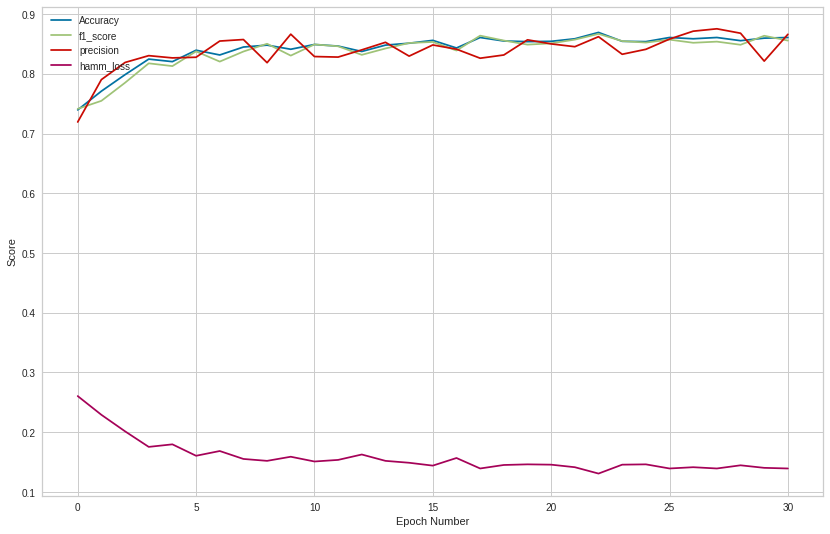

In [46]:
fig, ax = plt.subplots(figsize=(14, 9))
ax.plot(list(acc_epocs.keys()), list(acc_epocs.values()), label="Accuracy")
ax.plot(list(f1_score_epochs.keys()), list(f1_score_epochs.values()), label="f1_score")
ax.plot(list(precision_epocs.keys()), list(precision_epocs.values()), label="precision")
ax.plot(list(hamm_loss_epocs.keys()), list(hamm_loss_epocs.values()), label="hamm_loss")
plt.grid(True)
ax.set_xlabel('Epoch Number')
ax.set_ylabel('Score')
plt.legend(loc="upper left")
plt.show()
fig.savefig("Scores_NN.pdf", bbox_inches='tight')

Here you can see that training loss and validation loss are decreased to epoch to epoch

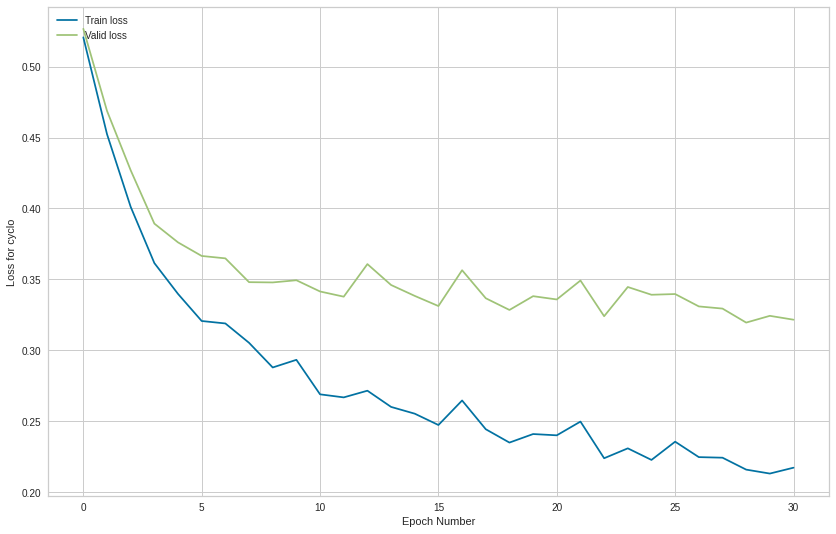

In [47]:
fig, ax = plt.subplots(figsize=(14, 9))
ax.plot(list(train_loss_epocs.keys()), list(train_loss_epocs.values()), label="Train loss")
ax.plot(list(valid_loss_epocs.keys()), list(valid_loss_epocs.values()), label="Valid loss")
plt.grid(True)
ax.set_xlabel('Epoch Number')
ax.set_ylabel('Loss for cyclo')
plt.legend(loc="upper left")
plt.show()
fig.savefig("Loss.pdf", bbox_inches='tight')

# SVM classifier

In [0]:
import numpy as np
from sklearn import datasets, svm
import matplotlib.pyplot as plt

parameter_candidates = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
]

clf_svm = GridSearchCV(estimator=svm.SVC(), param_grid=parameter_candidates, n_jobs=-1)
clf_svm.fit(X_train, y_train)
print(clf_svm.best_params_) 

In [48]:
svm_best = svm.SVC(**{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf', 'probability': True})
svm_best.fit(X_train, y_train)

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [51]:
predictions = svm_best.predict(X_test)
report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.85      0.87       963
           1       0.85      0.90      0.87       918

    accuracy                           0.87      1881
   macro avg       0.87      0.87      0.87      1881
weighted avg       0.87      0.87      0.87      1881



# Pattern's importance ranking approach


Now we can find the largest contribution of a pattern by the following way:


1. We take as input a vector of patterns of a snippet
2. We will produce $N$ new vectors with 1 changed value, where $N$ is the number of non-zero patterns for a Java file.
For example, if the input value is the following:
\begin{array}{|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|}
        \hline
6&0&2&0&0&0&1&1&0&0&0&0&0&0&1&0&0&0&6&5&0&0&1 \\ \hline
\end{array}

Changed values are the following:

$
\begin{array}{|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|l|}
        \hline
pattern\_index &&&&&&&&&&&&&&&&&&&&&&& \\ \hline
0&5&0&2&0&0&0&1&1&0&0&0&0&0&0&1&0&0&0&6&5&0&0&1 \\ \hline
2&6&0&1&0&0&0&1&1&0&0&0&0&0&0&1&0&0&0&6&5&0&0&1 \\ \hline
6&6&0&2&0&0&0&0&1&0&0&0&0&0&0&1&0&0&0&6&5&0&0&1 \\ \hline
7&6&0&2&0&0&0&1&0&0&0&0&0&0&0&1&0&0&0&6&5&0&0&1 \\ \hline
14&6&0&2&0&0&0&1&1&0&0&0&0&0&0&0&0&0&0&6&5&0&0&1 \\ \hline
18&6&0&2&0&0&0&1&1&0&0&0&0&0&0&1&0&0&0&5&5&0&0&1 \\ \hline
19&6&0&2&0&0&0&1&1&0&0&0&0&0&0&1&0&0&0&6&4&0&0&1 \\ \hline
22&6&0&2&0&0&0&1&1&0&0&0&0&0&0&1&0&0&0&6&5&0&0&0 \\ \hline
\end{array}
$

3. We find all combinations between the source array and the vectors given after changing 1 value
4. Then we use trained classifier to order each pair to get the `partially ordered set`
5. Then we do a *topological sort*.

In [0]:
from itertools import chain, tee
import networkx
import networkx.algorithms

def topological_sort(sublists):
    graph = networkx.DiGraph(sublists)
    networkx.draw(graph, with_labels=True, font_weight='bold')
    return list(networkx.algorithms.topological_sort(graph))

In [0]:
import networkx as nx
from collections import defaultdict, OrderedDict

def rank_patterns(arr, model):
  '''
  Takes snippet's patterns list and classifier and returns the idecies
  of patterns sorted by importance

  Args:
    arr (List[int]): List of patterns
    model: SVM model
  
  '''
  changed_arrs = []
  for i, item in enumerate(arr):
    elem = arr[i]
    if elem <= 0:
      continue
    else:
      arr_new = arr.copy()
      arr_new[i] = arr[i] - 1
      changed_arrs.append([i, arr_new])
  
  orders = []
  preds = defaultdict(dict)
  for elem1, elem2 in combinations(changed_arrs, 2):
    index_1 = elem1[0]
    index_2 = elem2[0]
    input_data = [elem1[1] + elem2[1]]
    pred_p = model.predict_proba(input_data)
    pred = model.predict(input_data)
    if pred == 1:
      orders.append([elem1[0], elem2[0]])
    else:
      orders.append([elem2[0], elem1[0]])

  try:
    res = topological_sort(orders)
    return res
  except nx.NetworkXUnfeasible as e:
    print('We have a cycle in a graph, use another method')
    return 0


Here we can see the result of preferences and the graph

Combinations of patterns to rank: [8, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 7, 0, 0, 0]
The ranked indicies:  [19, 18, 0, 4]


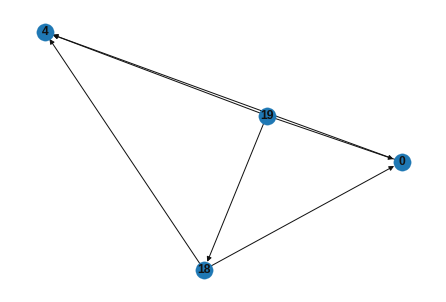

In [84]:
test_val = df[ONLY_PATTERNS].values[2].tolist()
print("Combinations of patterns to rank:", test_val)
ranked_list = rank_patterns(test_val, svm_best)
print('The ranked indicies: ', ranked_list)